<a href="https://colab.research.google.com/github/RATFIVE/GEOMAR-DeepLearning/blob/main/app/backend/small-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
#from google.colab import drive
#drive.mount('/content/drive')

## Clone the data from GitHub

In [30]:
"""
import os
if not os.path.exists('GEOMAR-DeepLearning'):
    print(f'GEOMAR-DeepLearning does not exist')
    !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git
    %cd GEOMAR-DeepLearning/app/backend
    !git pull
    !pip install -r requirements.txt
else:
    print(f'GEOMAR-DeepLearning exists')
    %cd GEOMAR-DeepLearning/app/backend
    !git pull
    !pip install -r requirements.txt

"""

"\nimport os\nif not os.path.exists('GEOMAR-DeepLearning'):\n    print(f'GEOMAR-DeepLearning does not exist')\n    !git clone https://github.com/RATFIVE/GEOMAR-DeepLearning.git\n    %cd GEOMAR-DeepLearning/app/backend\n    !git pull\n    !pip install -r requirements.txt\nelse:\n    print(f'GEOMAR-DeepLearning exists')\n    %cd GEOMAR-DeepLearning/app/backend\n    !git pull\n    !pip install -r requirements.txt\n\n"

## Import Libaries

In [31]:
# import all necessary libraries
import copy
import os
from PIL import Image
from IPython.display import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from sklearn import metrics
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.tensorboard import SummaryWriter
import datetime
from utils.Copernicus import AdvancedCopernicus
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
from tqdm import tqdm
# Ignore SettingWithCopyWarning:
warnings.filterwarnings("ignore", category=pd.errors.SettingWithCopyWarning)



# Display all columns
pd.options.display.max_columns = None
#pd.options.display.max_rows = None

## Import Data

In [32]:
file_path = f'data/output-2024-01-01-1.075874074001014.nc.json'

# Load json
df_model = pd.read_json(file_path)

df_model.head(5)

,time,values,sla_target
0,2025-03-03 23:00:00,"[[[0.5016462207, 3.4978201389, 9.4861087799, 0...",-0.643745
1,2025-03-04 00:00:00,"[[[0.5016462207, 3.5039174557, 9.4817237854, 0...",-0.656438
2,2025-03-04 01:00:00,"[[[0.5016462207, 3.5085229874, 9.5023069382, 0...",-0.637845
3,2025-03-04 02:00:00,"[[[0.5016462207, 3.5117938519000003, 9.5238676...",-0.603989
4,2025-03-04 03:00:00,"[[[0.5016462207, 3.5170764923, 9.5729150772, 0...",-0.566797


In [33]:
df_model.rename(columns={'values': 'data', 'sla_target': 'target'}, inplace=True)
df_model.sort_values(by=['time'], inplace=True)
print(df_model.info())
df_model.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   time    24 non-null     object 
 1   data    24 non-null     object 
 2   target  24 non-null     float64
dtypes: float64(1), object(2)
memory usage: 708.0+ bytes
None


,time,data,target
0,2025-03-03 23:00:00,"[[[0.5016462207, 3.4978201389, 9.4861087799, 0...",-0.643745
1,2025-03-04 00:00:00,"[[[0.5016462207, 3.5039174557, 9.4817237854, 0...",-0.656438
2,2025-03-04 01:00:00,"[[[0.5016462207, 3.5085229874, 9.5023069382, 0...",-0.637845
3,2025-03-04 02:00:00,"[[[0.5016462207, 3.5117938519000003, 9.5238676...",-0.603989
4,2025-03-04 03:00:00,"[[[0.5016462207, 3.5170764923, 9.5729150772, 0...",-0.566797


In [44]:
df_model["time"] = pd.to_datetime(df_model["time"])

# Letzten Zeitwert finden
last_time = df_model["time"].max()

# 48 Stunden zurückrechnen
start_time = last_time - pd.Timedelta(hours=48)
print(f"Start Time: {start_time}")
print(f"End Time: {last_time}")

# Daten der letzten 48 Stunden filtern
df_model_test = df_model[df_model["time"] >= start_time]
df_model_train = df_model[df_model["time"] < start_time]
display(df_model_train)
display(df_model_test)

Start Time: 2025-03-02 22:00:00
End Time: 2025-03-04 22:00:00


,time,data,target


,time,data,target
0,2025-03-03 23:00:00,"[[[0.5016462207, 3.4978201389, 9.4861087799, 0...",-0.643745
1,2025-03-04 00:00:00,"[[[0.5016462207, 3.5039174557, 9.4817237854, 0...",-0.656438
2,2025-03-04 01:00:00,"[[[0.5016462207, 3.5085229874, 9.5023069382, 0...",-0.637845
3,2025-03-04 02:00:00,"[[[0.5016462207, 3.5117938519000003, 9.5238676...",-0.603989
4,2025-03-04 03:00:00,"[[[0.5016462207, 3.5170764923, 9.5729150772, 0...",-0.566797
5,2025-03-04 04:00:00,"[[[0.5016462207, 3.5247027874, 9.6089229584, 0...",-0.520998
6,2025-03-04 05:00:00,"[[[0.5016462207, 3.5306749344, 9.626502037, 0....",-0.507128
7,2025-03-04 06:00:00,"[[[0.5016462207, 3.5341999531, 9.6551189423, 0...",-0.477990
8,2025-03-04 07:00:00,"[[[0.5016462207, 3.53282094, 9.6785774231, 0.0...",-0.446702
9,2025-03-04 08:00:00,"[[[0.5016462207, 3.5317759514000002, 9.6710710...",-0.472556


In [35]:
display(df_model_train.head())
display(df_model_train.info())

display(df_model_test.head())
display(df_model_test.info())

,time,data,target


<class 'pandas.core.frame.DataFrame'>
Index: 0 entries
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    0 non-null      datetime64[ns]
 1   data    0 non-null      object        
 2   target  0 non-null      float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 0.0+ bytes


None

,time,data,target
0,2025-03-03 23:00:00,"[[[0.5016462207, 3.4978201389, 9.4861087799, 0...",-0.643745
1,2025-03-04 00:00:00,"[[[0.5016462207, 3.5039174557, 9.4817237854, 0...",-0.656438
2,2025-03-04 01:00:00,"[[[0.5016462207, 3.5085229874, 9.5023069382, 0...",-0.637845
3,2025-03-04 02:00:00,"[[[0.5016462207, 3.5117938519000003, 9.5238676...",-0.603989
4,2025-03-04 03:00:00,"[[[0.5016462207, 3.5170764923, 9.5729150772, 0...",-0.566797


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   time    24 non-null     datetime64[ns]
 1   data    24 non-null     object        
 2   target  24 non-null     float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 708.0+ bytes


None

In [36]:
# Scale the data
# train_shape = np.array(df_model_train['data'].values[0]).shape
# train_scaler = StandardScaler()
# for i in range(0, len(df_model_train['data'])):
#     df_model_train['data'].iloc[i] = train_scaler.fit_transform(np.array(df_model_train['data'].iloc[i]).reshape(-1, 1))
#     df_model_train['data'].iloc[i] = df_model_train['data'].iloc[i].reshape(train_shape)


# test_shape = np.array(df_model_test['data'].values[0]).shape
# for i in range(0, len(df_model_test['data'])):
#     df_model_test['data'].iloc[i] = train_scaler.transform(np.array(df_model_test['data'].iloc[i]).reshape(-1, 1))
#     df_model_test['data'].iloc[i] = df_model_test['data'].iloc[i].reshape(test_shape)

# Scale the target
# target_scaler = StandardScaler()
# target_shape = np.array(df_model_train['target'].values[0]).shape
# for i in range(0, len(df_model_train['target'])):
#     df_model_train['target'].iloc[i] = target_scaler.fit_transform(np.array(df_model_train['target'].iloc[i]).reshape(-1, 1))
#     df_model_train['target'].iloc[i] = df_model_train['target'].iloc[i].reshape(target_shape)

# for i in range(0, len(df_model_test['target'])):
#     df_model_test['target'].iloc[i] = target_scaler.transform(np.array(df_model_test['target'].iloc[i]).reshape(-1, 1))
#     df_model_test['target'].iloc[i] = df_model_test['target'].iloc[i].reshape(target_shape)


In [37]:
df_model_train.head(5)

,time,data,target


In [38]:
df_model_train['target'].describe()

count    0.0
mean     NaN
std      NaN
min      NaN
25%      NaN
50%      NaN
75%      NaN
max      NaN
Name: target, dtype: float64

In [39]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader

class OceanDataset(Dataset):
    def __init__(self, df, input_size=24, output_size=6):
        self.input_size = input_size
        self.output_size = output_size

        self.X = np.array(df["data"].tolist())  # Shape (N, 40, 38, 11)
        self.y = np.array(df["target"].tolist())  # Shape (N,)

        self.X_seq, self.y_seq = self.create_sequences()

        print(self.X_seq.shape, self.y_seq.shape)

    def create_sequences(self):
        X_seq, y_seq = [], []
        for i in range(len(self.X) - self.input_size - self.output_size + 1):
            X_seq.append(self.X[i:i+self.input_size])  # Vergangene T Stunden
            y_seq.append(self.y[i+self.input_size:i+self.input_size+self.output_size])  # Zukunft H Stunden
        return np.array(X_seq), np.array(y_seq)

    def __len__(self):
        return len(self.X_seq)

    def __getitem__(self, idx):
        return torch.tensor(self.X_seq[idx], dtype=torch.float32), torch.tensor(self.y_seq[idx], dtype=torch.float32)

# Funktion zum Erstellen eines dynamischen Datasets
def create_dataloader(df, input_size=24, output_size=6, batch_size=16):
    dataset = OceanDataset(df, input_size, output_size)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)


In [40]:
# import torch.nn as nn

# class LSTMPredictor(nn.Module):
#     def __init__(self, input_size=11, hidden_size=64, num_layers=2, output_size=6):
#         super(LSTMPredictor, self).__init__()
#         self.hidden_size = hidden_size
#         self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
#         self.fc = nn.Linear(hidden_size, output_size)  # Dynamische Vorhersagegröße

#     def forward(self, x):
#         batch_size, seq_len, lat, lon, features = x.shape  # (B, T, 40, 38, 11)
#         x = x.mean(dim=(2, 3))  # Mittelt über Lat/Lon → (B, T, 11)
#         lstm_out, _ = self.lstm(x)
#         out = self.fc(lstm_out[:, -1, :])  # Letzten Zeitschritt für die Vorhersage nutzen
#         return out


# # Modell initialisieren
# model = LSTMPredictor(input_size=11, hidden_size=64, num_layers=2, output_size=6)
# print(model)


In [41]:
import torch
import torch.nn as nn

class OceanWaterLevelPredictor(nn.Module):
    def __init__(self, X_data, hidden_dim=64, num_layers=2, forecast_horizon=6):
        super(OceanWaterLevelPredictor, self).__init__()

        self.forecast_horizon = forecast_horizon  # Dynamische Vorhersagedauer

        # Convolutional Block (räumliche Merkmale extrahieren)
        self.conv1 = nn.Conv2d(in_channels=15, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()

        # Berechnung der CNN-Ausgabegröße für LSTM
        self.lstm_input_size = self._get_lstm_input_size(X_data)

        # LSTM Block (zeitliche Abhängigkeiten lernen)
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Fully Connected Layer (Endvorhersage)
        self.fc = nn.Linear(hidden_dim, self.forecast_horizon)  # Dynamisch anpassbare Stunden-Vorhersage

    def _get_lstm_input_size(self, X_data):
        """Berechnet die korrekte input_size für das LSTM anhand der CNN-Ausgabegröße"""
        with torch.no_grad():  # Kein Gradient-Tracking nötig
            batch_size, time_steps, lat, lon, features = X_data.shape

            # Dummy-Eingabe mit (Batch*Time, Features, H, W)
            dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)

            # CNN-Durchlauf
            x = self.pool(self.relu(self.conv1(dummy_input)))
            x = self.pool(self.relu(self.conv2(x)))

            _, c, h, w = x.shape  # Output-Shape nach CNN
            return c * h * w  # LSTM-Eingangsgröße berechnen

    def forward(self, x):
        batch_size, time_steps, lat, lon, features = x.shape

        # CNN Feature Extraction
        x = x.view(batch_size * time_steps, features, lat, lon)  # Zeit + Batch für CNN kombinieren
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Reshape für LSTM
        x = x.view(batch_size, time_steps, -1)  # (Batch, Zeit, Features)

        # LSTM für Sequenzverarbeitung
        x, _ = self.lstm(x)

        # Letzten Zeitschritt nehmen und durch FC-Schicht für flexible Vorhersage
        x = self.fc(x[:, -1, :])

        return x  # Ausgabeform: (Batch, forecast_horizon)


In [42]:
# Hyperparameter
epochs = 60
learning_rate = 0.001
input_size = 48  # 24 Stunden in der Vergangenheit
output_size = 10  # 10 Stunden Vorhersage (anpassbar)
batch_size = 16

# DataLoader erstellen
train_loader = create_dataloader(df_model_train, input_size=input_size, output_size=output_size, batch_size=batch_size)
dummy_X = train_loader.dataset.X_seq[0:]
# Dummy-Tensor mit korrekter Shape (Batch, Time, Lat, Lon, Features)
dummy_X = torch.randn(batch_size, dummy_X.shape[1], dummy_X.shape[2], dummy_X.shape[3], dummy_X.shape[4])  # Beispiel mit Batch=8, Time=24, Lat=40, Lon=38, Features=11

print(dummy_X.shape)
# Modell mit Dummy-Daten initialisieren
model = OceanWaterLevelPredictor(dummy_X, hidden_dim=64, num_layers=2, forecast_horizon=output_size)


criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training Loop
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
model.to(device)

for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")


# bring x_batch and y_batch to the device


(0,) (0,)


ValueError: num_samples should be a positive integer value, but got num_samples=0

In [ ]:
# Dataset erstellen (ohne DataLoader)
dataset = OceanDataset(df_model_test, input_size=input_size, output_size=output_size)

# Letzte bekannte Sequenz nehmen
X_new = torch.tensor(dataset.X_seq[-1:], dtype=torch.float32).to(device)  

model.eval()
with torch.no_grad():
    y_pred = model(X_new)
    print(f"Vorhersage für die nächsten {dataset.output_size} Stunden:", y_pred.cpu().numpy())


(4744, 48, 9, 10, 15) (4744, 10)
Vorhersage für die nächsten 10 Stunden: [[-0.26405305 -0.28514364 -0.3110874  -0.34192762 -0.3658464  -0.38490683
  -0.38321722 -0.3762596  -0.36245832 -0.3423037 ]]


(10,)
(10,)


/tmp/ipykernel_10124/3840421644.py:25: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_axis = pd.date_range(start=start_time, periods=len(y_true), freq="H")


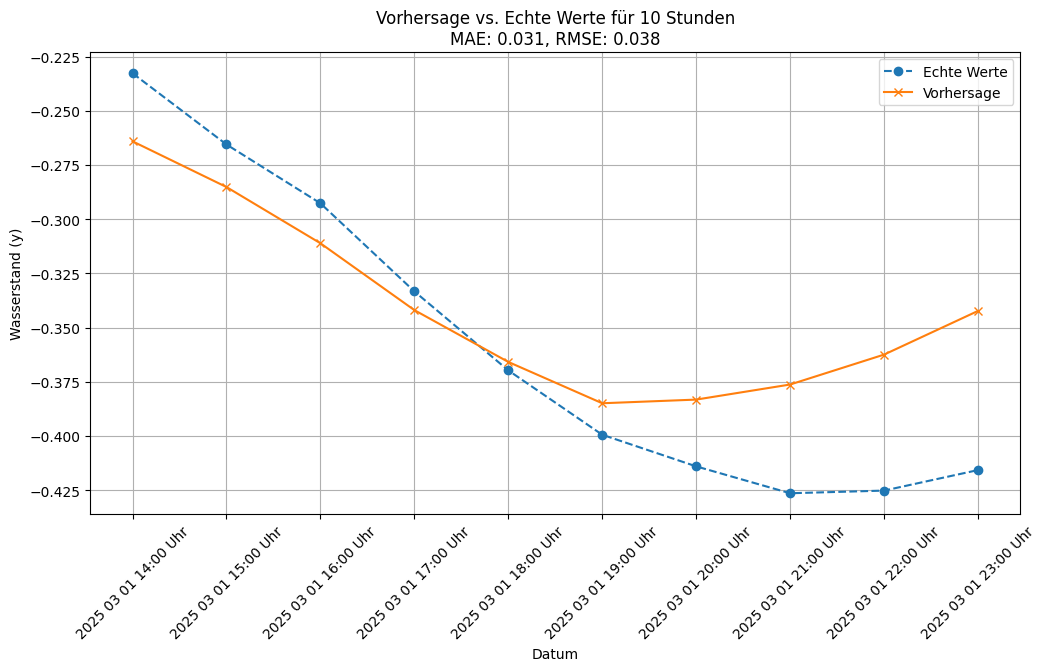

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
slector = 1

# Letzte bekannte Sequenz als Input für das Modell
X_new = torch.tensor(dataset.X_seq[-slector:], dtype=torch.float32).to(device)
y_true = dataset.y_seq[-slector]  # Echte Werte

print(y_true.shape)
# Vorhersage berechnen
model.eval()
with torch.no_grad():
    y_pred = model(X_new).cpu().numpy().flatten()
y_pred = y_pred[:len(y_true)]  # Nur so viele Werte wie echte Werte
print(y_pred.shape)
# Fehlermetriken berechnen
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

# Zeitachse erstellen (letzte bekannte Zeit + Vorhersagehorizont)
start_time = df_model_test["time"].iloc[-1]  # Letzter bekannter Zeitpunkt
time_axis = pd.date_range(start=start_time, periods=len(y_true), freq="H")

# **Plot erstellen**
plt.figure(figsize=(12, 6))
plt.plot(time_axis, y_true, label="Echte Werte", marker="o", linestyle="dashed")
plt.plot(time_axis, y_pred, label="Vorhersage", marker="x", linestyle="solid")

# x-Achse mit gewünschtem Datumsformat
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y %m %d %H:%M Uhr"))

# Achsen, Titel und Legende
plt.xlabel("Datum")
plt.ylabel("Wasserstand (y)")
plt.title(f"Vorhersage vs. Echte Werte für {dataset.output_size} Stunden\nMAE: {mae:.3f}, RMSE: {rmse:.3f}")
plt.legend()
plt.grid()
plt.show()


In [ ]:
dd

NameError: name 'dd' is not defined

## Create Learning and Target data

In [ ]:
df_data = df_model[['time', 'values']]
df_data.head(5)

KeyError: "['values'] not in index"

In [ ]:
df_target = df_model[['time', 'sla_target']]
df_target.head(5)

,time,sla_target
0,2025-02-01 00:00:00,-0.120450
1,2025-02-01 01:00:00,-0.091966
2,2025-02-01 02:00:00,-0.065222
3,2025-02-01 03:00:00,-0.014131
4,2025-02-01 04:00:00,0.020769


In [ ]:
learning_data = df_model['values']
learning_data = list(learning_data)
learning_data = np.array(learning_data)
print(learning_data.shape)

(101, 40, 38, 11)


In [ ]:
target = df_model['sla_target']
target = list(target)
target = np.array(target)
print(target.shape)

(101,)


## Scale the data


In [ ]:
number_of_data_points = len(learning_data)
print(number_of_data_points)

image_heigt = learning_data.shape[1]
print(image_heigt)

image_width = learning_data.shape[2]
print(image_width)

number_of_features = learning_data.shape[3]
print(number_of_features)

101
40
38
11


In [ ]:
import numpy as np
import torch

def create_overlapping_windows(data, target, window_size=24, pred_size=24, stride=1):
    """
    Erstellt Overlapping Windows aus den Zeitseriendaten.

    Args:
        data (np.array): Eingabe mit Shape (T, 40, 38, 11)
        target (np.array): Wasserpegel mit Shape (T, 1)
        window_size (int): Länge des Eingabefensters
        pred_size (int): Länge des vorherzusagenden Zeitraums
        stride (int): Schrittweite zwischen Fenstern

    Returns:
        X_windows (torch.Tensor): Eingaben (Batch, window_size, 40, 38, 11)
        y_windows (torch.Tensor): Targets (Batch, pred_size)
    """
    X_windows = []
    y_windows = []

    T = data.shape[0]  # Anzahl der Zeitschritte

    for i in range(0, T - window_size - pred_size + 1, stride):
        X_windows.append(data[i:i + window_size])  # Letzte 24 Stunden
        y_windows.append(target[i + window_size: i + window_size + pred_size].flatten())  # Nächste 24 Stunden

    X_windows = np.array(X_windows)  # (Batch, 24, 40, 38, 11)
    y_windows = np.array(y_windows)  # (Batch, 24)

    return torch.tensor(X_windows, dtype=torch.float32), torch.tensor(y_windows, dtype=torch.float32)

# Dummy-Daten erzeugen
#T = 101  # 101 Zeitpunkte
#data = np.random.rand(T, 40, 38, 11)  # Shape (101, 40, 38, 11)
#target = np.random.rand(T, 1)  # Shape (101, 1)

# Overlapping Windows erstellen
X, y = create_overlapping_windows(learning_data, target, window_size=24, pred_size=24, stride=1)

print("X shape:", X.shape)  # (Batch, 24, 40, 38, 11)
print("y shape:", y.shape)  # (Batch, 24)


X shape: torch.Size([54, 24, 40, 38, 11])
y shape: torch.Size([54, 24])


In [ ]:
def setup_experiment(dataset, target, seq_len, pred_len, test_share, val_share, scaler, ignored_last_month, stride=1):
    
    # Skalierung der Daten
    #scaled_data = scaler.fit_transform(learning_data.reshape(-1, 1)).reshape(learning_data.shape)
    #scaled_target = scaler.transform(target.reshape(-1, 1)).reshape(target.shape)

    sc_train = MinMaxScaler()
    sc_target = MinMaxScaler()

    print(dataset.shape)
    print(target.shape)
    # Erstelle überlappende Fenster mit der Funktion create_overlapping_windows
    X, y = create_overlapping_windows(dataset, target, window_size=seq_len, pred_size=pred_len, stride=stride)

    # Entferne die letzten ignorierten Monate
    used_vec_length = len(y) - ignored_last_month

    # Berechne die Größen für die Trainings-, Validierungs- und Testdaten
    test_size = int(used_vec_length * test_share)
    val_size = int(used_vec_length * val_share)
    train_size = used_vec_length - test_size - val_size

    # Indizes für das Aufteilen der Daten
    index_val_start = train_size
    index_test_start = train_size + val_size

    # Aufteilen der Daten
    x_train = X[0:index_val_start]
    y_train = y[0:index_val_start]
    x_val = X[index_val_start:index_test_start]
    y_val = y[index_val_start:index_test_start]
    x_test = X[index_test_start:used_vec_length]
    y_test = y[index_test_start:used_vec_length]

    x_train = sc_train.fit_transform(x_train.reshape(-1, 1)).reshape(-1, pred_len, image_heigt, image_width, number_of_features)
    y_train = sc_target.fit_transform(y_train.reshape(-1, 1)).reshape(-1, pred_len)

    x_val = sc_train.transform(x_val.reshape(-1, 1)).reshape(-1, pred_len, image_heigt, image_width, number_of_features)
    y_val = sc_target.transform(y_val.reshape(-1, 1)).reshape(-1, pred_len)
    
    x_test = sc_train.transform(x_test.reshape(-1, 1)).reshape(-1, pred_len, image_heigt, image_width, number_of_features)
    y_test = sc_target.transform(y_test.reshape(-1, 1)).reshape(-1, pred_len)



    return x_train, y_train, x_val, y_val, x_test, y_test, sc_train, sc_target


# Beispielaufruf der setup_experiment Funktion
x_train, y_train, x_val, y_val, x_test, y_test, sc_train, sc_target = setup_experiment(
    dataset=learning_data,  # Deine Eingabedaten
    target=target,  # Deine Zielwerte (z.B. Wasserpegel)
    seq_len=24,  # Fenstergröße (24 Stunden)
    pred_len=6,  # Vorhersagezeitraum (24 Stunden)
    test_share=0.2,  # 20% für Testdaten
    val_share=0.1,  # 10% für Validierungsdaten
    scaler=MinMaxScaler(),  # Skalierer (z.B. MinMaxScaler)
    ignored_last_month=0  # Keine letzten Monate ignorieren
)


(101, 40, 38, 11)
(101,)


In [ ]:
print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)


x_train shape: (204, 6, 40, 38, 11)
y_train shape: (51, 6)
x_val shape: (28, 6, 40, 38, 11)
y_val shape: (7, 6)
x_test shape: (56, 6, 40, 38, 11)
y_test shape: (14, 6)


In [ ]:
# Convert Numpy Arrays to Torch Tensor
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_val = torch.tensor(x_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class OceanWaterLevelPredictor(nn.Module):
    def __init__(self, X_data, hidden_dim=64, num_layers=2):
        super(OceanWaterLevelPredictor, self).__init__()

        # Convolutional Block (räumliche Merkmale extrahieren)
        self.conv1 = nn.Conv2d(in_channels=11, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.relu = nn.ReLU()


        # LSTM Block (zeitliche Abhängigkeiten lernen)
        # Calculate input size for LSTM
        # Assuming output of conv2 is (batch_size, 64, lat/2, lon/2) after pooling
        # You might need to adjust these dimensions based on your actual data and pooling layers.
        # For example if the dummy_input has dimensions (8, 24, 40, 38, 11),
        # the Conv2d and max pooling operation will result into (batch, 64, 10, 9)
        # which results in an input_size for the LSTM of 9 * 10 * 64 = 5760
        # (adjust to the dimensions of learning data)
        #self.lstm_input_size = 9 * 10 * 64  # Adjust these based on CNN output size
        # Berechnung der CNN-Ausgabegröße mit Dummy-Daten
        self.lstm_input_size = self._get_lstm_input_size(X_data)
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=hidden_dim, num_layers=num_layers, batch_first=True)

        # Fully Connected Layer (Endvorhersage)
        self.fc = nn.Linear(hidden_dim, 24)  # 24 Stunden Vorhersage

    def _get_lstm_input_size(self, X_data):
        """Berechnet die korrekte input_size für das LSTM anhand der CNN-Ausgabegröße"""
        input_shape = X_data.shape
        #print(input_shape)  # Print the shape to inspect
        length_of_data = len(X_data)
        #print(length_of_data)  # Print the length to inspect

        # Check the number of dimensions and unpack accordingly
        if len(input_shape) == 5:
            batch_size, time_steps, lat, lon, features = (length_of_data, *input_shape[1:])  # Unpack for 5D input
        elif len(input_shape) == 4:  # Assuming 4D input (Batch, lat, lon, features)
            batch_size, lat, lon, features = (length_of_data, *input_shape[1:])
            time_steps = 1  # Set time_steps to 1 for 4D input
        else:
            raise ValueError(f"Unexpected input shape: {input_shape}. Expected 4 or 5 dimensions.")

        dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)  # (Batch*Time, Features, H, W)

        dummy_input = torch.randn(batch_size * time_steps, features, lat, lon)  # (Batch*Time, Features, H, W)

        x = self.pool(self.relu(self.conv1(dummy_input)))
        x = self.pool(self.relu(self.conv2(x)))

        _, c, h, w = x.shape  # Output-Shape nach CNN
        return c * h * w  # LSTM-Eingangsgröße berechnen

    def forward(self, x):
        batch_size, time_steps, lat, lon, features = x.shape
        x = x.view(batch_size * time_steps, features, lat, lon)  # Kombiniere Zeit + Batch für CNN

        # CNN Feature Extraction
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))

        # Reshape for LSTM, calculating the correct input size
        x = x.view(batch_size, time_steps, -1)  # Reshape before LSTM

        # LSTM für Sequenzverarbeitung
        x, _ = self.lstm(x)

        # Letzten Zeitschritt nehmen und durch FC-Schicht für 24-Stunden-Prognose
        x = self.fc(x[:, -1, :])

        return x  # Ausgabeform: (Batch, 24)

# Testmodell
model = OceanWaterLevelPredictor(X_data=X)
#dummy_input = torch.randn(8, 24, 40, 38, 11)  # Batch=8, 24 Zeitpunkte, räumliche Größe (40,38), 11 Features
output = model(X)
print(output.shape)  # Erwartet: (8, 24)

torch.Size([54, 24])


In [ ]:
from torch.utils.data import Dataset, DataLoader

class OceanDataset(Dataset):
    def __init__(self, data, target, window_size=24, pred_size=24, stride=1):
        self.X, self.y = create_overlapping_windows(data, target, window_size, pred_size, stride)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

dataset = OceanDataset(learning_data, target)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

for X_batch, y_batch in dataloader:
    print(X_batch.shape, y_batch.shape)  # (8, 24, 40, 38, 11) und (8, 24)
    break

torch.Size([8, 24, 40, 38, 11]) torch.Size([8, 24])


In [ ]:

dropout_results = [] # storing the results of the dropout experiment

from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
import copy

def training(model, x_train, y_train, x_val, y_val, criterion, optimizer, epochs, batch_size=8, verbose=False):

    # Set device to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



    # Move model to device
    model.to(device)

    # Initialize best metrics and model
    best_eval_metric_val = -float('inf')  # Initialize the best evaluation metric
    best_val_loss = float('inf')  # Initialize the best validation loss
    best_model = copy.deepcopy(model.state_dict())  # Initialize the best model
    patience_counter_loss = 0  # Early stopping counter for loss
    patience_counter_metric = 0  # Early stopping counter for evaluation metric

    # DataLoader for training data
    train_dataset = TensorDataset(x_train, y_train)
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    # DataLoader for validation data
    val_dataset = TensorDataset(x_val, y_val)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

    # Scheduler for learning rate adjustment
    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

    # Training Loop
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        # Training loop
        for data, target in train_dataloader:
            data, target = data.to(device), target.to(device)

            optimizer.zero_grad()  # Clear gradients
            outputs = model(data)  # Forward pass
            loss = criterion(outputs, target)  # Calculate loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update weights

            epoch_loss += loss.item()  # Accumulate batch loss

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for data, target in val_dataloader:
                data, target = data.to(device), target.to(device)
                outputs = model(data)
                loss = criterion(outputs, target)
                val_loss += loss.item()

        # Print status
        if verbose:
            print(f"| Epoch {epoch+1} | Train Loss: {epoch_loss / len(train_dataloader):.4f} | Val Loss: {val_loss / len(val_dataloader):.4f}")

        # Check if the validation loss improved
        scheduler.step(val_loss)  # Adjust learning rate if necessary

        # Early stopping based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())  # Save the best model
            patience_counter_loss = 0
        else:
            patience_counter_loss += 1

        # Early stopping if no improvement for 'patience' epochs
        if patience_counter_loss >= 10:
            print("Early stopping due to no improvement in validation loss.")
            break

    # Load the best model
    model.load_state_dict(best_model)
    print(f"Best validation loss: {best_val_loss:.4f}")

    return model


criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
epochs = 1000
best_model = training(model, x_train, y_train, x_val, y_val, criterion, optimizer, epochs, batch_size=8, verbose=True)



AssertionError: Size mismatch between tensors

(10, 24, 40, 38, 11)
(10, 24)
(10, 24)


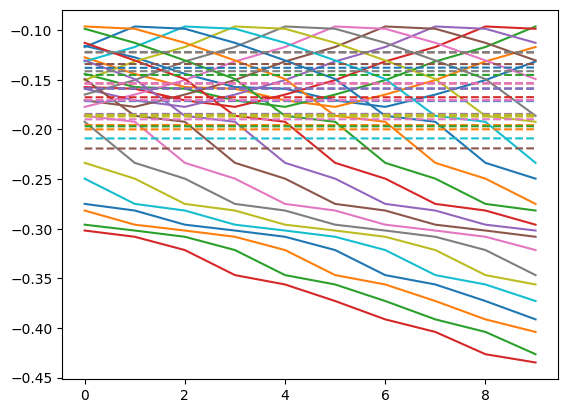

In [ ]:
# Überprüfe, ob das Modell auf der GPU oder der CPU ist
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Das Modell auf das entsprechende Gerät verschieben
model.to(device)

# Die Eingabedaten auch auf das gleiche Gerät verschieben
x_test = x_test.to(device)

# Vorhersagen mit dem Modell
model.eval()
with torch.no_grad():
    y_pred = model(x_test)


x_test_shape = x_test.shape
y_pred_shape = y_pred.shape
y_test_shape = y_test.shape


# Retransform the scaled data back to original values
x_test = sc_train.inverse_transform(x_test.reshape(1,-1).cpu().numpy()).reshape(x_test_shape)
y_test = sc_target.inverse_transform(y_test.cpu().numpy())
y_pred = sc_target.inverse_transform(y_pred.cpu().numpy())


print(x_test.shape)
print(y_pred.shape)
print(y_test.shape)
# Plotten der Ergebnisse
plt.plot(y_test, label="Echter Wasserstand")
plt.plot(y_pred, label="Vorhergesagter Wasserstand", linestyle="dashed")
#plt.legend()
plt.show()


In [ ]:
y_test

array([[-0.11589777],
       [-0.12743758],
       [-0.14408432],
       [-0.15739799],
       [-0.1590482 ],
       [-0.17076336],
       [-0.17732596],
       [-0.16494468],
       [-0.15032972],
       [-0.13154283],
       [-0.11702421],
       [-0.09635945],
       [-0.09867847],
       [-0.11284269],
       [-0.13053873],
       [-0.14928272],
       [-0.18631516],
       [-0.19234832],
       [-0.23369525],
       [-0.2496091 ],
       [-0.27504018],
       [-0.28172356],
       [-0.2959765 ],
       [-0.30186895],
       [-0.12743758],
       [-0.14408432],
       [-0.15739799],
       [-0.1590482 ],
       [-0.17076336],
       [-0.17732596],
       [-0.16494468],
       [-0.15032972],
       [-0.13154283],
       [-0.11702421],
       [-0.09635945],
       [-0.09867847],
       [-0.11284269],
       [-0.13053873],
       [-0.14928272],
       [-0.18631516],
       [-0.19234832],
       [-0.23369525],
       [-0.2496091 ],
       [-0.27504018],
       [-0.28172356],
       [-0

In [ ]:
x_test = x_test.reshape(-1, image_heigt, image_width, number_of_features)
y_test = y_test.reshape(-1, 1)



print(x_test.shape)
print(y_test.shape)

# convert np array to list
x_test_list = x_test.tolist()
y_test_list = y_test.tolist()

(240, 40, 38, 11)
(240, 1)


In [ ]:
df_compare = pd.DataFrame({'x_test': x_test_list, 'y_test': y_test_list})

# Convert x_test to numpy array 
df_compare['x_test'] = df_compare['x_test'].apply(lambda x: np.array(x))

In [ ]:
df_compare.head(5)

,x_test,y_test
0,"[[[0.5016462206840515, 3.9722084999084473, 10....",[-0.1158977746963501]
1,"[[[0.5016462206840515, 3.971322536468506, 10.0...",[-0.12743757665157318]
2,"[[[0.5016462206840515, 3.97041392326355, 10.09...",[-0.14408431947231293]
3,"[[[0.5016462206840515, 3.9694836139678955, 10....",[-0.15739798545837402]
4,"[[[0.5016462206840515, 3.9685769081115723, 10....",[-0.1590481996536255]


In [ ]:
# # Round each value in df_compare['x_test'] to 2 decimal places
#df_compare['x_test'] = df_compare['x_test'].apply(lambda x: np.round(x, 10))
display(df_compare.head(2))
display(df_model.head(2))

,x_test,y_test
0,"[[[0.5016462206840515, 3.9722084999084473, 10....",[-0.1158977746963501]
1,"[[[0.5016462206840515, 3.971322536468506, 10.0...",[-0.12743757665157318]


,time,values,sla_target
0,2025-02-01 00:00:00,"[[[0.5016462207, 3.9498741627, 11.4310970306, ...",-0.120450
1,2025-02-01 01:00:00,"[[[0.5016462207, 3.9476611614, 11.4490509033, ...",-0.091966


In [ ]:
display(df_compare['x_test'].head(2))
display(df_model['values'].head(2))

0    [[[0.5016462206840515, 3.9722084999084473, 10....
1    [[[0.5016462206840515, 3.971322536468506, 10.0...
Name: x_test, dtype: object

0    [[[0.5016462207, 3.9498741627, 11.4310970306, ...
1    [[[0.5016462207, 3.9476611614, 11.4490509033, ...
Name: values, dtype: object

In [ ]:
import pandas as pd
import numpy as np


# Sicherstellen, dass 'time' als datetime gespeichert ist
df_model['time'] = pd.to_datetime(df_model['time'])

# Leere Liste für die gefundenen Zeitstempel
time_stamps = []
rtol = 1e-6  # relative Toleranz
atol = 1e-7  # absolute Toleranz
# Iteriere über jede Zeile in x_test_df
for x_test_value in df_compare['x_test']:
    # Suche nach einer Übereinstimmung in df_model['values']
    matching_row = df_model[df_model['values'].apply(lambda val: np.allclose(np.array(val), np.array(x_test_value), rtol=rtol, atol=atol))]  # Vergleicht Listen
    if not matching_row.empty:
        time_stamps.append(matching_row['time'].values[0])  # Entnehme den Zeitstempel der passenden Zeile
    else:
        time_stamps.append(None)  # Falls keine Übereinstimmung gefunden wurde

# Füge die Zeitstempel als neue Spalte in df_compare hinzu
df_compare['time'] = time_stamps

display(df_compare.head(2))

,x_test,y_test,time
0,"[[[0.5016462206840515, 3.9722084999084473, 10....",[-0.1158977746963501],2025-02-02 20:00:00
1,"[[[0.5016462206840515, 3.971322536468506, 10.0...",[-0.12743757665157318],2025-02-02 21:00:00


In [ ]:
df_compare['time'] = pd.to_datetime(df_compare['time'])
df_model['time '] = pd.to_datetime(df_model['time'])

# Umbenennen der 'time' Spalte in df_model, um Kollisionen zu vermeiden
df_model.rename(columns={'time ': 'time_model'}, inplace=True)

# Merge der DataFrames
df_merged = pd.merge(df_compare, df_model, on='time', how='left', suffixes=('_compare', '_model')).sort_values('time', ascending=True).reset_index(drop=True)

# Anzeigen der ersten Zeilen und Informationen
display(df_merged)


,x_test,y_test,time,values,sla_target,time_model,time_model,time_model,time_model,time_model,time_model
0,"[[[0.5016462206840515, 3.9722084999084473, 10....",[-0.1158977746963501],2025-02-02 20:00:00,"[[[0.5016462207, 3.9722084999, 10.0884838104, ...",-0.024878,2025-02-02 20:00:00,2025-02-02 20:00:00,2025-02-02 20:00:00,2025-02-02 20:00:00,2025-02-02 20:00:00,2025-02-02 20:00:00
1,"[[[0.5016462206840515, 3.971322536468506, 10.0...",[-0.12743757665157318],2025-02-02 21:00:00,"[[[0.5016462207, 3.971322298, 10.0891113281, 0...",-0.023530,2025-02-02 21:00:00,2025-02-02 21:00:00,2025-02-02 21:00:00,2025-02-02 21:00:00,2025-02-02 21:00:00,2025-02-02 21:00:00
2,"[[[0.5016462206840515, 3.971322536468506, 10.0...",[-0.12743757665157318],2025-02-02 21:00:00,"[[[0.5016462207, 3.971322298, 10.0891113281, 0...",-0.023530,2025-02-02 21:00:00,2025-02-02 21:00:00,2025-02-02 21:00:00,2025-02-02 21:00:00,2025-02-02 21:00:00,2025-02-02 21:00:00
3,"[[[0.5016462206840515, 3.97041392326355, 10.09...",[-0.14408431947231293],2025-02-02 22:00:00,"[[[0.5016462207, 3.9704136848, 10.0931568146, ...",-0.029188,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00
4,"[[[0.5016462206840515, 3.97041392326355, 10.09...",[-0.14408431947231293],2025-02-02 22:00:00,"[[[0.5016462207, 3.9704136848, 10.0931568146, ...",-0.029188,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00
5,"[[[0.5016462206840515, 3.97041392326355, 10.09...",[-0.14408431947231293],2025-02-02 22:00:00,"[[[0.5016462207, 3.9704136848, 10.0931568146, ...",-0.029188,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00,2025-02-02 22:00:00
6,"[[[0.5016462206840515, 3.9694836139678955, 10....",[-0.15739798545837402],2025-02-02 23:00:00,"[[[0.5016462207, 3.969483614, 10.0990476608, 0...",-0.022875,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00
7,"[[[0.5016462206840515, 3.9694836139678955, 10....",[-0.15739798545837402],2025-02-02 23:00:00,"[[[0.5016462207, 3.969483614, 10.0990476608, 0...",-0.022875,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00
8,"[[[0.5016462206840515, 3.9694836139678955, 10....",[-0.15739798545837402],2025-02-02 23:00:00,"[[[0.5016462207, 3.969483614, 10.0990476608, 0...",-0.022875,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00
9,"[[[0.5016462206840515, 3.9694836139678955, 10....",[-0.15739798545837402],2025-02-02 23:00:00,"[[[0.5016462207, 3.969483614, 10.0990476608, 0...",-0.022875,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00,2025-02-02 23:00:00


In [ ]:
target

array([-0.12045024, -0.09196629, -0.0652215 , -0.0141305 ,  0.02076891,
        0.04214397,  0.04532179,  0.03102981, -0.00940779, -0.04803707,
       -0.09498295, -0.11728118, -0.14950308, -0.14442956, -0.13383524,
       -0.100039  , -0.07533465, -0.04387525, -0.03279964, -0.02849848,
       -0.03017926, -0.05317787, -0.06148703, -0.07514369, -0.09272623,
       -0.09443453, -0.09561975, -0.07716461, -0.06180112, -0.05546167,
       -0.05430328, -0.05645074, -0.07610948, -0.09836343, -0.11976808,
       -0.13300967, -0.1511465 , -0.15249293, -0.1462993 , -0.13242179,
       -0.10301366, -0.076516  , -0.05486151, -0.03465199, -0.02487777,
       -0.02353018, -0.029188  , -0.02287522, -0.01518352, -0.01004106,
        0.00940467,  0.03202527,  0.05779597,  0.06865667,  0.06958765,
        0.06107175,  0.04193813,  0.00342809, -0.02556995, -0.06954814,
       -0.09545866, -0.12843999, -0.13570079, -0.14142251, -0.1377527 ,
       -0.12784426, -0.11800981, -0.11310173, -0.11589777, -0.12